## Compare reconstruction to quad scan

In [1]:
import torch
from copy import deepcopy
from torch.utils.data import DataLoader, Dataset, random_split
from torchensemble import VotingRegressor, SnapshotEnsembleRegressor
import matplotlib.pyplot as plt
from fitting import create_ensemble, CustomLoss, get_data, get_datasets

import sys
sys.path.append("../")

folder = ""
all_k, all_images, bins, xx = get_data(folder)
train_dset, test_dset = get_datasets(all_k, all_images)

all_k = all_k.cpu()
all_images = all_images.cpu()

bandwidth = torch.tensor(0.0)
ensemble = create_ensemble(bins, bandwidth)

from torchensemble.utils import io
io.load(ensemble, ".")
ensemble = ensemble


/global/homes/r/rroussel/.conda/envs/phase_space_reconstruction/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def calc_rms_size(xx, images):
    # note image sums are normalized to 1
    xx_ = xx[0].unsqueeze(0).unsqueeze(0).repeat(*images.shape[:2], 1, 1).to(images)
    yy_ = xx[1].unsqueeze(0).unsqueeze(0).repeat(*images.shape[:2], 1, 1).to(images)
    proj_x = images.sum(dim=-1)
    proj_y = images.sum(dim=-2)
    
    x = xx_[...,:,0]
    y = yy_[...,0,:]
    
    mean_x = torch.sum(x * proj_x, dim=-1).unsqueeze(-1)
    mean_y = torch.sum(y * proj_y, dim=-1).unsqueeze(-1)
    
    var_x = torch.sum((x - mean_x)**2 * proj_x, dim=-1).unsqueeze(-1)
    var_y = torch.sum((y - mean_y)**2 * proj_y, dim=-1).unsqueeze(-1)
    
    # calculate cross covariance
    #var_xy = torch.sum((xx_ - mean_x)*(yy_ - mean_y)*images, dim=-1).unsqueeze(-1)

    return torch.cat([mean_x, mean_y], dim=-1), torch.cat([var_x, var_y], dim=-1)
    
means, variances = calc_rms_size(xx, all_images)

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse


In [3]:
train_k = train_dset.k
train_k = train_k.cuda()

train_im = train_dset.images
train_im = train_im.cpu()

test_k = test_dset.k
test_k = test_k.cuda()

test_im = test_dset.images
test_im = test_im.cpu()

In [4]:
recompute_images = True
ensemble = ensemble.cpu()
with torch.no_grad():
    if recompute_images:
        dist = torch.distributions.MultivariateNormal(torch.zeros(6), torch.eye(6))
        custom_beam = None#dist.sample([100000]).cuda()
    
        model_pred = torch.cat(
            [ensemble[i](all_k[:,:1].cpu())[0].unsqueeze(0) for i in range(len(ensemble))]
        )
        model_pred = torch.transpose(model_pred.squeeze(dim=2), 0,1)
        model_pred = model_pred.cpu().detach()
        
        torch.save(model_pred, "all_pred_images.pt")
    else:
        model_pred = torch.load("all_pred_images.pt")


In [5]:
print(all_images.shape)
model_pred.shape

torch.Size([21, 4, 180, 180])


torch.Size([21, 2, 180, 180])

torch.Size([21, 2, 180, 180])
torch.Size([21, 4, 180, 180])


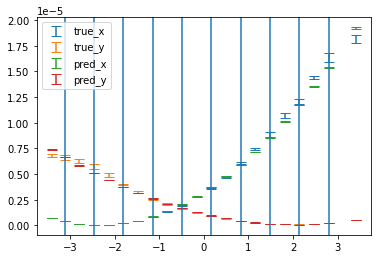

In [6]:
# plot quad scan
means, variances = calc_rms_size(xx, all_images)


fig,ax = plt.subplots()
k = all_k[:, 0]
mean_variance = torch.mean(variances, dim=-2)
error_variance = torch.std(variances, dim=-2)

ax.errorbar(k, mean_variance[...,0], error_variance[...,0],capsize=5,ls='', label="true_x")
ax.errorbar(k, mean_variance[...,1], error_variance[...,1],capsize=5,ls='', label="true_y")

print(model_pred.shape)
print(all_images.shape)
pmeans, pvariances = calc_rms_size(xx, model_pred)

mean_pvariance = torch.mean(pvariances, dim=-2)
error_pvariance = torch.std(pvariances, dim=-2)

#ax.plot(k, pvariances[...,0],'o')
#ax.plot(k, pvariances[...,1],'o')

ax.errorbar(k, mean_pvariance[...,0], error_pvariance[...,0],capsize=5,ls='', label="pred_x")
ax.errorbar(k, mean_pvariance[...,1], error_pvariance[...,1],capsize=5,ls='', label="pred_y")

for ele in range(1,20,2):
    ax.axvline(all_k[ele,0])
    
ax.legend()

In [7]:
all_k[:,0]

tensor([-3.4185, -3.1302, -2.8007, -2.4712, -2.1417, -1.8122, -1.4827, -1.1532,
        -0.8237, -0.4942, -0.1647,  0.1647,  0.4942,  0.8237,  1.1532,  1.4827,
         1.8122,  2.1417,  2.4712,  2.8007,  3.4185], dtype=torch.float64)

tensor([-3.4185, -3.1302, -2.8007, -2.4712], dtype=torch.float64)


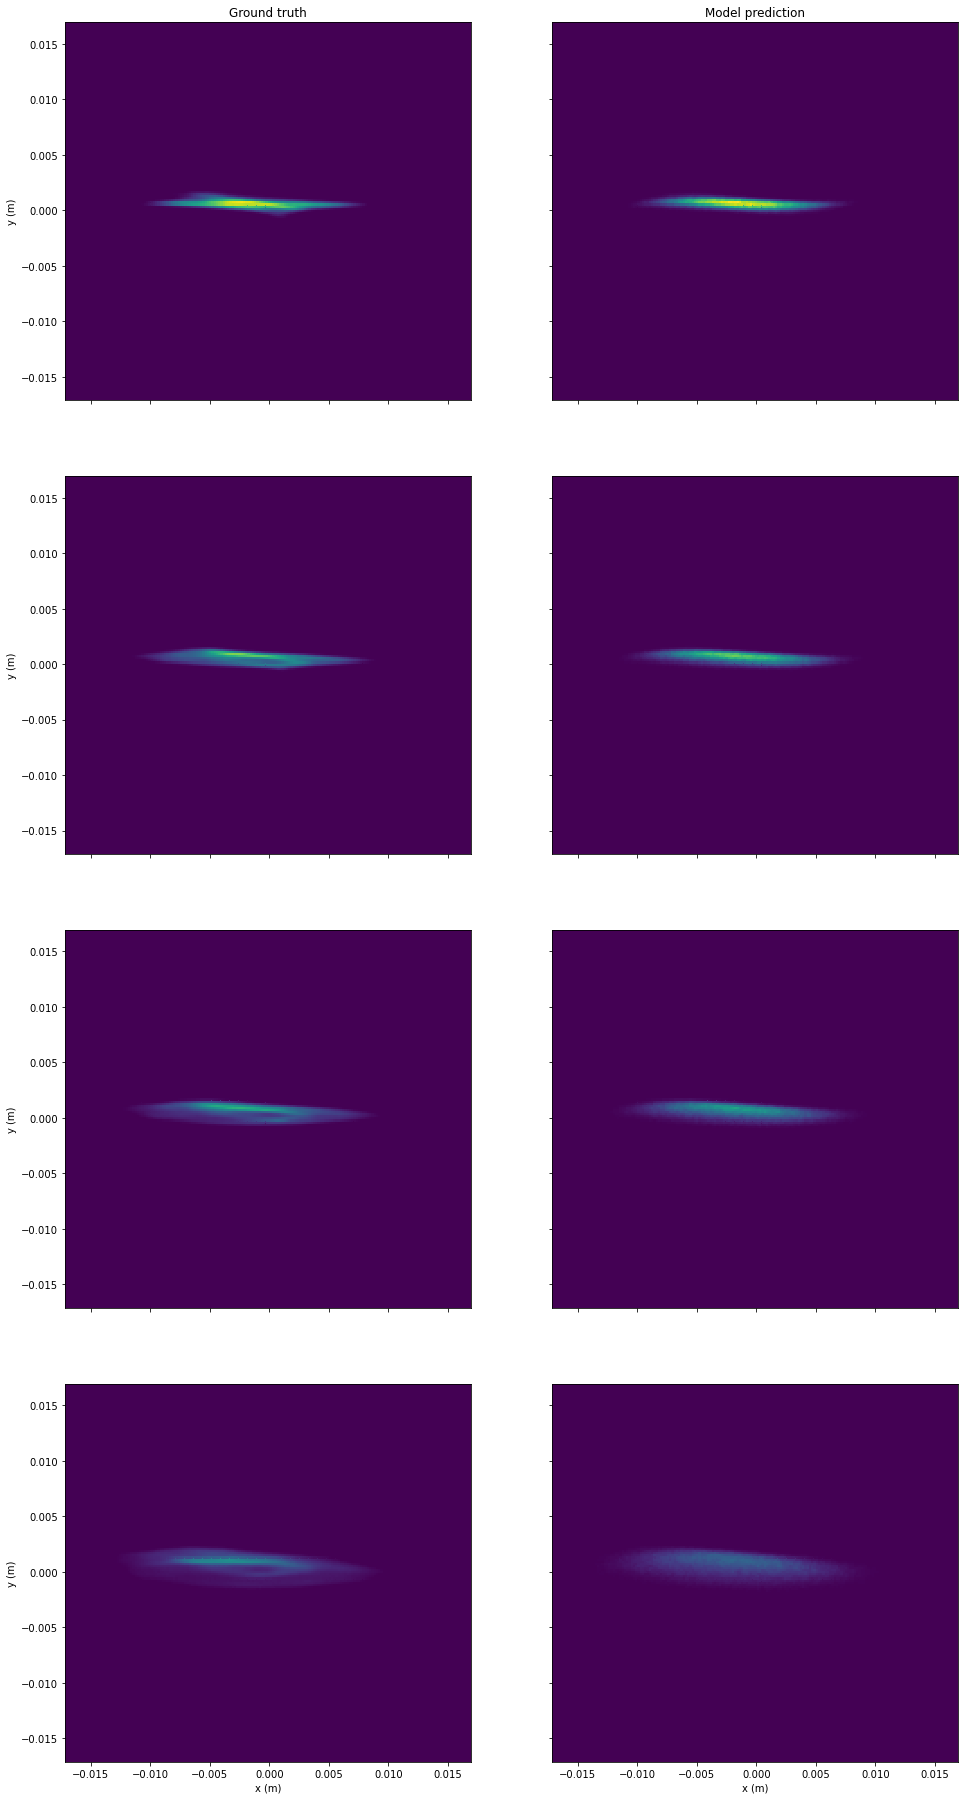

In [8]:
from visualization import compare_images
print(all_k[:4,0])
fig5 = compare_images(xx, model_pred[-4:,0], all_images[-4:,0])
#fig = compare_images(xx, model_pred[:6,0], all_images[:6,0])
fig5.set_size_inches(16,32)

In [9]:
from fitting import weighted_mse_loss
diff = weighted_mse_loss(all_images[:,0], model_pred[:,0])
print(diff[0].sum())
print(diff.sum())
fig,ax = plt.subplots()
c = ax.imshow(diff[0])
fig.colorbar(c)

ImportError: cannot import name 'weighted_mse_loss' from 'fitting' (/global/u1/r/rroussel/phase_space_reconstruction/AWA/fitting.py)

In [ ]:
from visualization import compare_image_projections
fig = compare_image_projections(xx[0].T[0], model_pred[-4:], all_images[-4:])
fig.set_size_inches(20,20)

In [ ]:
test_k[:,0]

In [ ]:
test_image = model_pred[0,0]
pool = torch.nn.MaxPool2d(3)
plt.imshow(test_image)
plt.figure()
plt.imshow(pool(test_image.unsqueeze(0))[0])